In [10]:
import os
import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU

In [11]:
directory = 'images'

files = os.listdir(directory)

In [12]:
x_train=[]
x_test=[]

y_train=[]
y_test=[]

for i in range(0,100):
    added=[]
    img = Image.open(directory+'\\'+files[i])
    img=img.resize((28,28))
    for i0 in range(28):
        for i1 in range(28):
            added.append(img.getpixel((i1,i0)))
    x_train.append([added])
    y_train.append(1)

for i in range(101,150):
    added=[]
    img = Image.open(directory+'\\'+files[i])
    img=img.resize((28,28))
    for i0 in range(28):
        for i1 in range(28):
            added.append(img.getpixel((i1,i0)))
    x_test.append([added])
    y_test.append(1)


x_train=np.array(x_train)
x_test=np.array(x_test)

y_train=np.array(y_train)
y_test=np.array(y_test)

x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 3))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 3))

BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 5

BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]

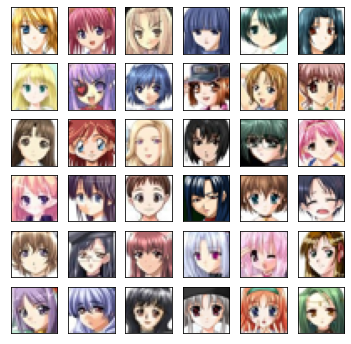

In [4]:
size=6

plt.figure(figsize=(size, size))
num=1
for i in range(0, size):
    for j in range(0, size):
        ax = plt.subplot(size, size, num)
        plt.imshow(x_test[num-1, :, :, :])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        num += 1
plt.show()

In [13]:
hidden_dim = 2

generator = tf.keras.Sequential([
    Dense(7 * 7 * 256, activation='relu', input_shape=(hidden_dim,)),
    BatchNormalization(),
    Reshape((7, 7, 256)),
    Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'),
])
#print(generator.summary())


discriminator = tf.keras.Sequential([
    Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 3]),
    LeakyReLU(),
    Dropout(0.3),
    Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    LeakyReLU(),
    Dropout(0.3),
    Flatten(),
    Dense(1),
])
#print(discriminator.summary())

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, hidden_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


def train(dataset, epochs):
    history = []
    MAX_PRINT_LABEL = 10
    th = BUFFER_SIZE // (BATCH_SIZE * MAX_PRINT_LABEL)

    for epoch in range(1, epochs + 1):
        
        is_print=(epoch % print_step == 2)
        if is_print:
            print(f'{epoch}/{EPOCHS}: ', end='')

        start = time.time()
        n = 0
        
        gen_loss_epoch = 0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch += K.mean(gen_loss)
            if (n % th == 0 and is_print): print('=', end='')
            n += 1
            
        history += [gen_loss_epoch / n]
        if is_print:
            print(': ' + str(history[-1]))
            print('Время эпохи {} составляет {} секунд'.format(epoch, time.time() - start))
            print('Примерное оставшееся время: {} секунд'.format(int((time.time() - start)*(epochs - epoch))))
            print('')

    return history

In [10]:
EPOCHS = 2000
print_step = 200
history = train(train_dataset, EPOCHS)

2/2000: ==========: tf.Tensor(0.8020733, shape=(), dtype=float32)
Время эпохи 2 составляет 0.7215862274169922 секунд
Примерное оставшееся время: 1441 секунд

202/2000: ==========: tf.Tensor(0.8815242, shape=(), dtype=float32)
Время эпохи 202 составляет 0.8545100688934326 секунд
Примерное оставшееся время: 1536 секунд

402/2000: ==========: tf.Tensor(0.88063383, shape=(), dtype=float32)
Время эпохи 402 составляет 0.7895481586456299 секунд
Примерное оставшееся время: 1261 секунд

602/2000: ==========: tf.Tensor(0.8649236, shape=(), dtype=float32)
Время эпохи 602 составляет 0.715590238571167 секунд
Примерное оставшееся время: 1000 секунд

802/2000: ==========: tf.Tensor(0.8893129, shape=(), dtype=float32)
Время эпохи 802 составляет 0.6866071224212646 секунд
Примерное оставшееся время: 822 секунд

1002/2000: ==========: tf.Tensor(1.0498981, shape=(), dtype=float32)
Время эпохи 1002 составляет 0.8155317306518555 секунд
Примерное оставшееся время: 813 секунд

1202/2000: ==========: tf.Tensor

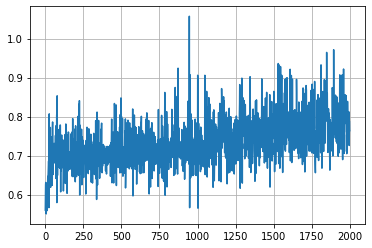

In [9]:
plt.plot(history)
plt.grid(True)
plt.show()

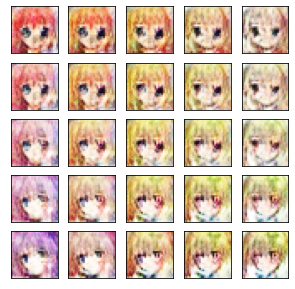

In [19]:
n = 2
total = 2 * n + 1

plt.figure(figsize=(total, total))

num = 1
for i in range(-n, n + 1):
  for j in range(-n, n + 1):
    ax = plt.subplot(total, total, num)
    num += 1
    img = generator.predict(np.expand_dims([0.5 * i / n, 0.5 * j / n], axis=0))
    plt.imshow(img[0, :, :, :])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

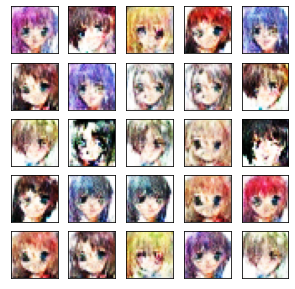

In [18]:
n = 2
total = 2 * n + 1

plt.figure(figsize=(total, total))

num = 1
for i in range(-n, n + 1):
  for j in range(-n, n + 1):
    ax = plt.subplot(total, total, num)
    num += 1
    img = generator.predict(tf.random.normal([1, hidden_dim]))
    plt.imshow(img[0, :, :, :])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [16]:
generator.save("generator")
discriminator.save("discriminator")

INFO:tensorflow:Assets written to: generator\assets
INFO:tensorflow:Assets written to: discriminator\assets


In [17]:
generator = tf.keras.models.load_model("generator")
discriminator = tf.keras.models.load_model("discriminator")